In [3328]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, ConfusionMatrixDisplay
from torch.optim import lr_scheduler
import torch.nn.functional as F

In [3329]:
np.random.seed(111)
torch.manual_seed(111)
torch.cuda.manual_seed(111)

In [3330]:
data_train = pd.read_csv(
    "https://media.githubusercontent.com/media/psi3471/datasets/main/disease_prediction/disease_train.csv"
).drop(columns=["Unnamed: 0"])

data_test = pd.read_csv(
    "https://media.githubusercontent.com/media/psi3471/datasets/main/disease_prediction/disease_test.csv"
).drop(columns=["Unnamed: 0"])

In [3331]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.features = dataframe.iloc[:, :-1].values
        self.labels = dataframe.iloc[:, -1].values

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        x = torch.tensor(self.features[index], dtype=torch.float32)
        y = torch.tensor(self.labels[index], dtype=torch.float32)
        return x, y

In [3332]:
train_dataset = CustomDataset(data_train)
test_dataset = CustomDataset(data_test)

In [3333]:
class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(data_train.iloc[:, -1].values), y = data_train.iloc[:, -1].values)
class_weights=torch.tensor(class_weights[1],dtype=torch.float)
 
print(class_weights)

tensor(1.4018)


In [3334]:
Nb = 64
train_loader = DataLoader(train_dataset, batch_size=Nb, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Nb, shuffle=False)

In [3335]:
class ModelSimple(nn.Module):

    # Geralmente, os blocos da rede são definidos no método __init__()
    def __init__(self):
        # Necessário chamar __init__() da classe mãe
        super().__init__()
        
        # Uma das formas de se definir um modelo é a sequencial
        self.model = nn.Sequential(
            # Entrada com 8 elementos
            nn.Linear(8, 1)
        )

    # O método forward() define como é feito o cálculo progressivo
    # para obter a saída da rede, a partir da entrada x.
    # Nesse caso, como foi definido um modelo sequencial em
    # self.model, basta chamar self.model(x)
    def forward(self, x):
        output = self.model(x)
        return output

In [3336]:
class ModelComplex(nn.Module):
    # Geralmente, os blocos da rede são definidos no método __init__()
    def __init__(self, neurons_list, args):
        # Necessário chamar __init__() da classe mãe
        super().__init__()
        
        self.neurons_list = neurons_list
        
        self.n_layers = len(neurons_list)

        self.args = args

        # self.dropout = nn.Dropout(Dropout[1]) if Dropout[0] == True else nn.Dropout(0)
        # self.batch_normalization = nn.BatchNorm1d
        # self.activation_function = Activation
        
        self.layers = nn.ModuleDict()
        self.layers["input"] = nn.Linear(in_features = 8, out_features = neurons_list[0])

        for i in range(self.n_layers-1):
            self.layers[f"hidden_{i}"] = nn.Sequential(
                                         nn.Linear(neurons_list[i], neurons_list[i+1]),
                                         nn.BatchNorm1d(neurons_list[i+1]),
                                         *args)

        self.layers["output"] = nn.Linear(in_features=neurons_list[-1], out_features=1)
        
    # O método forward() define como é feito o cálculo progressivo
    # para obter a saída da rede, a partir da entrada x.
    # Nesse caso, como foi definido um modelo sequencial em
    # self.model, basta chamar self.model(x)
    def forward(self, x):
        x = self.layers["input"](x)
        
        for i in range(self.n_layers-1):
            x = self.layers[f"hidden_{i}"](x)
            
        return self.layers["output"](x)

In [3337]:
def train(model, filename, num_epochs = 100, learning_rate = 0.1):
    # Define the training parameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model, criterion, and optimizer
    model.to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    # Create empty lists to store the losses for plotting
    train_losses = []
    valid_losses = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Calculate average training loss for the epoch
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).unsqueeze(1)

                outputs = model(inputs)

                loss = criterion(outputs, labels)

                valid_loss += loss.item()

        # Calculate average validation loss for the epoch
        valid_loss /= len(test_loader)
        valid_losses.append(valid_loss)

        scheduler.step()
        
        # Print the training and validation losses for each epoch
        if (epoch + 1) % (num_epochs / 10) == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f}")

    torch.save(model.state_dict(), filename)
    # Plot the training and validation losses
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [3338]:
def test(model, filename):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.load_state_dict(torch.load(filename))
    model.eval()
    total_correct = 0
    total_samples = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(inputs)
            predicted = torch.round(torch.sigmoid(outputs))

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate test accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f'Test Accuracy: {accuracy * 100:.2f} %')

    # Calculate test precision
    precision = precision_score(true_labels, predicted_labels)
    print(f'Test Precision: {precision*100:.2f} %')

    # Calculate test recall
    recall = recall_score(true_labels, predicted_labels)
    print(f'Test recall: {recall*100:.2f} %')

    # Calculate test F1-score
    f1 = f1_score(true_labels, predicted_labels)
    print(f'Test F1-score: {f1*100:.2f} %')

    # Calculate test confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix = confusion)
    disp.plot()
    print('Test Confusion Matrix:')
    print(confusion)
    plt.show()

Epoch 10/100 - Train Loss: 1.2493 - Valid Loss: 0.6837
Epoch 20/100 - Train Loss: 0.7374 - Valid Loss: 0.6558
Epoch 30/100 - Train Loss: 0.6842 - Valid Loss: 0.6163
Epoch 40/100 - Train Loss: 0.6638 - Valid Loss: 0.6138
Epoch 50/100 - Train Loss: 0.7061 - Valid Loss: 0.6520
Epoch 60/100 - Train Loss: 0.6530 - Valid Loss: 0.6088
Epoch 70/100 - Train Loss: 0.6455 - Valid Loss: 0.6115
Epoch 80/100 - Train Loss: 0.6426 - Valid Loss: 0.6127
Epoch 90/100 - Train Loss: 0.6411 - Valid Loss: 0.6132
Epoch 100/100 - Train Loss: 0.6402 - Valid Loss: 0.6134


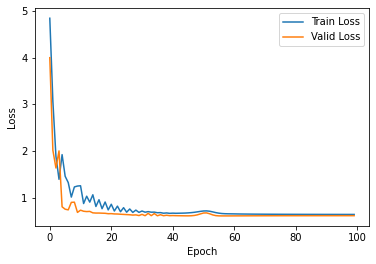

In [3339]:
train(ModelSimple(), "model_simple.pt", num_epochs = 100)

Test Accuracy: 74.68 %
Test Precision: 58.93 %
Test recall: 67.35 %
Test F1-score: 62.86 %
Test Confusion Matrix:
[[82 23]
 [16 33]]


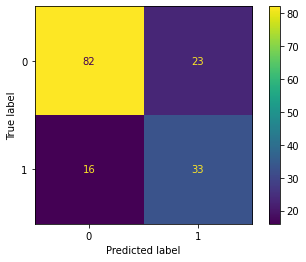

In [3340]:
test(ModelSimple(), "model_simple.pt")

Epoch 20/200 - Train Loss: 0.6853 - Valid Loss: 0.6149
Epoch 40/200 - Train Loss: 0.6399 - Valid Loss: 0.6249
Epoch 60/200 - Train Loss: 0.6568 - Valid Loss: 0.6205
Epoch 80/200 - Train Loss: 0.6656 - Valid Loss: 0.6145
Epoch 100/200 - Train Loss: 0.6324 - Valid Loss: 0.6145
Epoch 120/200 - Train Loss: 0.6349 - Valid Loss: 0.6136
Epoch 140/200 - Train Loss: 0.6639 - Valid Loss: 0.6154
Epoch 160/200 - Train Loss: 0.6407 - Valid Loss: 0.6160
Epoch 180/200 - Train Loss: 0.6498 - Valid Loss: 0.6154
Epoch 200/200 - Train Loss: 0.6354 - Valid Loss: 0.6156


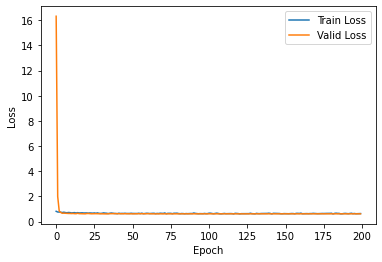

In [3341]:
neuron_list = [16, 32, 64, 64, 32, 16]

activation_function = nn.ReLU()
dropout = nn.Dropout(0.5)

args = [activation_function, dropout]

model_complex = ModelComplex(neuron_list, args)

train(model_complex, "model_complex.pt", num_epochs = 200)

Test Accuracy: 77.27 %
Test Precision: 64.00 %
Test recall: 65.31 %
Test F1-score: 64.65 %
Test Confusion Matrix:
[[87 18]
 [17 32]]


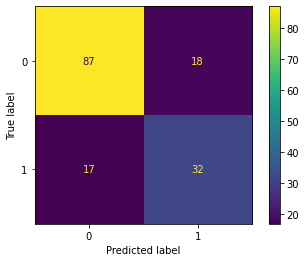

In [3342]:
test(model_complex, "model_complex.pt")